In [62]:
!nvidia-smi

Fri Nov 11 17:18:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   55C    P8    40W / 350W |   1500MiB / 12031MiB |     43%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np
import cupy as cp

In [14]:
data=pd.read_csv("result_interaction.csv")
interaction_array=np.array(data['Interaction'])
coordsx_array=np.array(data['x'])
coordsy_array=np.array(data['y'])
interaction_array = cp.array(interaction_array)

ValueError: Unsupported dtype object

In [7]:
data

,Id,x,y,Expression,Action,Gesture,Interaction
0,person1,182,234,Neutral,Sitting,Down,Reading Book
1,person1,176,224,Neutral,Sitting,Down,Reading Book
2,person1,174,218,Neutral,Sitting,Down,Reading Book
3,person1,174,214,Neutral,Sitting,Down,Reading Book
4,person1,173,208,Neutral,Sitting,Down,Reading Book
...,...,...,...,...,...,...,...
2592,person1,146,305,None,Sitting,Down,None
2593,person1,135,200,None,Standing,Down,None
2594,person1,128,77,None,Sitting,Down,None
2595,person1,130,115,None,Sitting,Down,None


/tmp/ipykernel_59445/2765174233.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l_1d, bins=50, ax=ax)


<AxesSubplot:xlabel='Value', ylabel='Density'>

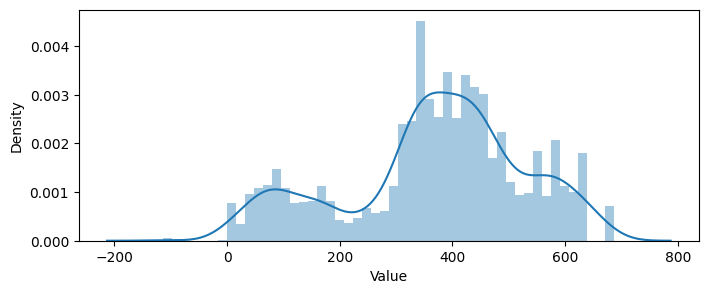

In [8]:
import seaborn as sns
x = data.iloc[:,2] 
K =3 #クラスタ数
l_1d = x.values.tolist()
l_1d
N = len(x) #観測データ数
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
ax.set_xlabel("Value")
sns.distplot(l_1d, bins=50, ax=ax)

In [9]:
import pymc3 as pm
# 各確率変数の確率分布の定義
with pm.Model() as model:
  mu = pm.Normal('mu', mu=[100,380,500], sigma=1.2, shape=K) #平均はガウス分布
  tau = pm.Gamma('tau', alpha=10, beta=5, shape=K) #精度はガンマ分布
  pi = pm.Dirichlet('pi', a=np.ones(K), shape=K) #混合比率はディリクレ分布
  category = pm.Categorical('category', p=pi, shape=N) #クラスタ割り当てのパラメータはカテゴリカル分布
  x_var = pm.Normal('x', mu=mu[category], tau=tau[category], observed=l_1d) #xはガウス分布

In [10]:
# ギブスサンプリングによるパラメータ推論 
with model:
    step1 = pm.Metropolis(vars=[mu, tau, pi])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    idata = pm.sample(10000, step=[step1, step2], tune=5000)

/tmp/ipykernel_59445/3415785353.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
/home/ozaki/.local/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [pi]
>>Metropolis: [tau]
>>Metropolis: [mu]
>ElemwiseCategorical: [category]


/home/ozaki/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/home/ozaki/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ozaki/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ozaki/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


In [ ]:
pm.plot_trace(idata) #各パラメータの事後分布の描画

NameError: name 'pm' is not defined

In [ ]:
from scipy import stats
# 所属クラスタのベイズ推論
def clustering(x, trace, n_sample = None):
    def likelihood(x, pi, mu, tau): 
      return pi * stats.norm.pdf(x, mu, 1./np.sqrt(tau)) 
    # 各パラメータの事後分布
    pi = trace['pi']
    mu = trace['mu']
    tau = trace['tau']
    slist = []
    if n_sample is None:
      n_sample = pi.shape[0] 
    for k in range(K): 
      s_k = list(map(lambda i:likelihood(x=x,pi=pi[i,k],mu=mu[i,k],tau=tau[i,k]),np.arange(n_sample))) 
      slist.append(s_k)
    #正規化
    slist = np.array(slist)
    nterm = slist.sum(axis=0) 
    p_k = (slist / nterm).T 
    return p_k

50


AttributeError: 'BarContainer' object has no attribute 'set_facecolor'

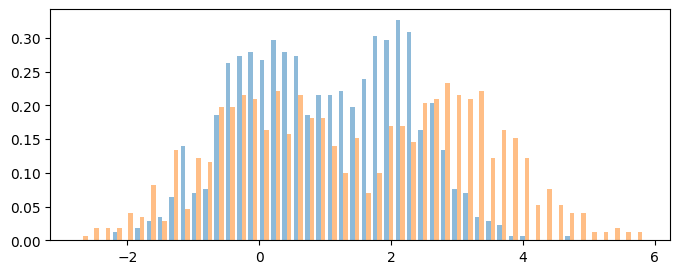

In [ ]:
# データの描画
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
vals, bins, patches = ax.hist(x, bins=50, density=True, alpha=0.5) 

# ビン毎の所属クラスタの確率
cluster_list = list(map(lambda x:clustering(x, idata, n_sample=1000).mean(axis=0),bins[1:]))
print(len(idata))
for i, p in enumerate(cluster_list): 
  patches[i].set_facecolor(p) #ビンに所属クラスタの色を描画
  print(i,p)
# 推論したパラメータの事後分布の平均を用いた所属クラスタの描画
xmin, xmax, ymin, ymax = ax.axis()
xl = np.linspace(xmin, xmax, 1000)
mpi = idata['pi'].mean(axis=0)
mmu = idata['mu'].mean(axis=0)
mtau = idata['tau'].mean(axis=0)
for k in range(K):
  pdf = mpi[k] * stats.norm(mmu[k], 1./np.sqrt(mtau[k])).pdf(xl)
  c = np.zeros(K)
  c[k] = 1
  ax.plot(xl, pdf, color=c, label='component:{}'.format(k))
ax.legend()

In [ ]:
data=pd.read_csv("result_interaction2.csv")
interaction_array=np.array(data['Interaction'])
coordsx_array=np.array(data['x'])
coordsy_array=np.array(data['y'])

In [ ]:
cluster_list[0]*255

array([  0.,   0., 255.])

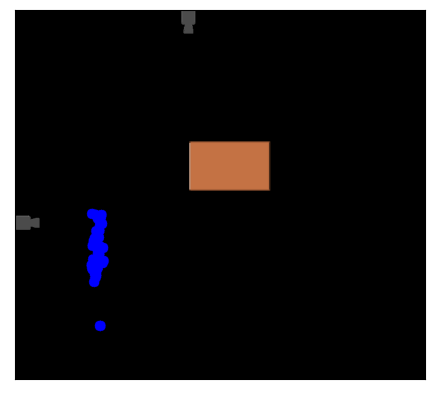

In [56]:
image=cv2.imread("ispace_frontier.png")
for i in range(len(cluster_list)-1):
  # if(interaction_array[i]=="Holding Book" or interaction_array[i]=="Reading Book"):
  #   pcolor=(255,0,0)
  # elif(interaction_array[i]=="Holding Phone" or interaction_array[i]=="Calling on Phone"):
  #   pcolor=(0,255,0)
  # elif(interaction_array[i]=="Working on Computer"):
  #   pcolor=(0,0,255)
  if(interaction_array[i]!="None"):
    cv2.circle(image, (coordsy_array[i]+66, 671-coordsx_array[i]), 10, cluster_list[0]*255, -1)

  plt.imshow(image)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(image)

In [19]:
cluster_list[0][2]

1.0

In [ ]:
print(patches)


NameError: ignored

In [ ]:
image=cv2.imread("/content/drive/MyDrive/ispace/ispace_frontier.png")
for i in range(len(interaction_array)-1):
  if(interaction_array[i]=="Holding Book" or interaction_array[i]=="Reading Book"):
    pcolor=(255,0,0)
  elif(interaction_array[i]=="Holding Phone" or interaction_array[i]=="Calling on Phone"):
    pcolor=(0,255,0)
  elif(interaction_array[i]=="Working on Computer"):
    pcolor=(0,0,255)
  if(interaction_array[i]!="None"):
    cv2.circle(image, (coordsy_array[i]+66, 671-coordsx_array[i]), 10, pcolor, -1)

  plt.imshow(image)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(image)